In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

#%load_ext autoreload
#%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

In [3]:
import IPython.display as ipd

In [13]:
def all_exp(alpha, beta, tau, temp, mixtures, model_name, data_size="search"):
    ipd.display(ipd.Markdown("**Simple SWS**"))
    model_sws, gmp_sws, res_sws = retrain_model(alpha, beta, tau, int(0), mixtures, model_name, data_size, "", False)
    show_sws_weights(model = model_sws, means = list(gmp_sws.means.data.clone().cpu()), precisions = list(gmp_sws.gammas.data.clone().cpu()))
    
    ipd.display(ipd.Markdown("**SWS KD**"))
    model_kd, gmp_kd, res_kd = retrain_model(alpha, beta, tau, temp, mixtures, model_name, data_size, "", False)
    show_sws_weights(model = model_kd, means = list(gmp_kd.means.data.clone().cpu()), precisions = list(gmp_kd.gammas.data.clone().cpu()))
    
    ipd.display(ipd.Markdown("**SWS KD Scaling**"))
    model_kd_s, gmp_kd_s, res_kd_s = retrain_model(alpha, beta, tau, temp, mixtures, model_name, data_size, "", True)
    show_sws_weights(model = model_kd_s, means = list(gmp_kd_s.means.data.clone().cpu()), precisions = list(gmp_kd_s.gammas.data.clone().cpu()))
    
    title = "Temp: {} Tau: {}\n".format(temp, tau)
    sws_res = "Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n".format(res_sws['compress_test'], res_sws['compress_val'], res_sws['prune_test'], res_sws['prune_val'], res_sws['sparsity'])
    kd_res = 'Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n'.format(res_kd['compress_test'], res_kd['compress_val'], res_kd['prune_test'], res_kd['prune_val'], res_kd['sparsity'])
    kd_s_res = 'Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n\n'.format(res_kd_s['compress_test'], res_kd_s['compress_val'], res_kd_s['prune_test'], res_kd_s['prune_val'], res_kd_s['sparsity'])
    res_str = title + sws_res + kd_res + kd_s_res
    print (res_str)
    
    return model_sws, gmp_sws, model_kd, gmp_kd, model_kd_s, gmp_kd_s, res_str

### Load good hyperparameters

In [5]:
with open("../search/sobol_search.p", "rb") as handle:
    params = pickle.load(handle)
i = 240
print ("exp:{} mean: {}, var: {}, tau: {}, temp: {}, mixtures: {}".format(i, params['mean'][i], params['var'][i], params['tau'][i], params['temp'][i], int(params['mixtures'][i])))
mean = float(params['mean'][i])
var = float(params['var'][i])
tau = float(params['tau'][i])
mixtures = int(params['mixtures'][i])
temp = float(params['temp'][i])
model_name = 'LeNet_300_100'
data_size = 'search'

exp:240 mean: 0.10181517217181825, var: 0.1034304555503225, tau: 6.479230606842127e-07, temp: 19.0, mixtures: 9


### Override Parameters

In [10]:
mixtures = 15
temp = 4
mean = 10
var = 10
beta = mean/var
alpha = mean * beta

**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.24
Epoch: 20. Test Accuracy: 97.36
Epoch: 30. Test Accuracy: 97.54
Epoch: 40. Test Accuracy: 97.69
Epoch: 50. Test Accuracy: 97.59
Retrain Test: 97.59, Retrain Validation: 0.00, Prune Test: 96.66, Prune Validation: 0.00, Prune Sparsity: 98.25


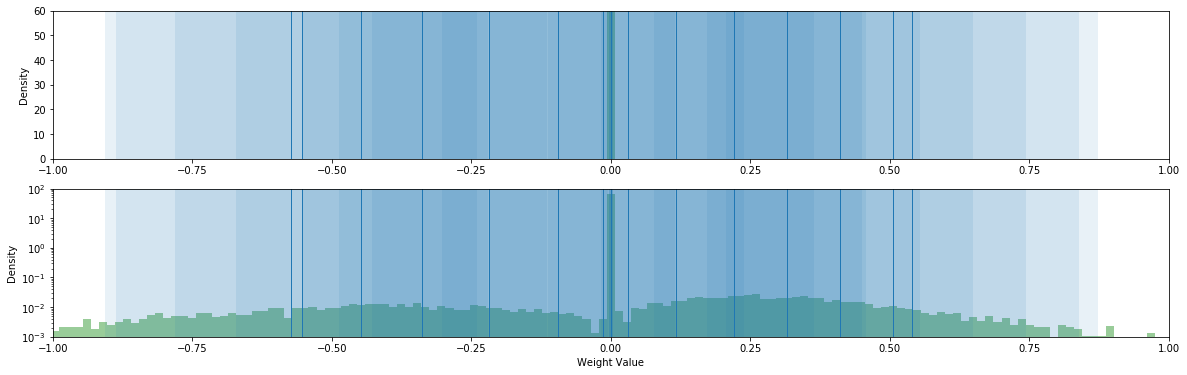

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.83
Epoch: 20. Test Accuracy: 98.12
Epoch: 30. Test Accuracy: 98.03
Epoch: 40. Test Accuracy: 98.03
Epoch: 50. Test Accuracy: 97.97
Retrain Test: 97.97, Retrain Validation: 0.00, Prune Test: 97.16, Prune Validation: 0.00, Prune Sparsity: 97.33


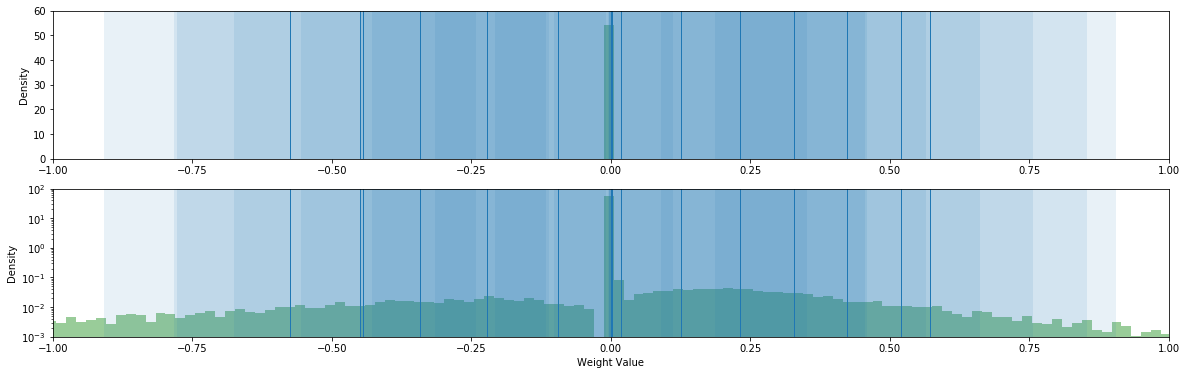

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.49
Epoch: 20. Test Accuracy: 98.08
Epoch: 30. Test Accuracy: 98.10
Epoch: 40. Test Accuracy: 98.02
Epoch: 50. Test Accuracy: 98.07
Retrain Test: 98.07, Retrain Validation: 0.00, Prune Test: 97.49, Prune Validation: 0.00, Prune Sparsity: 97.20


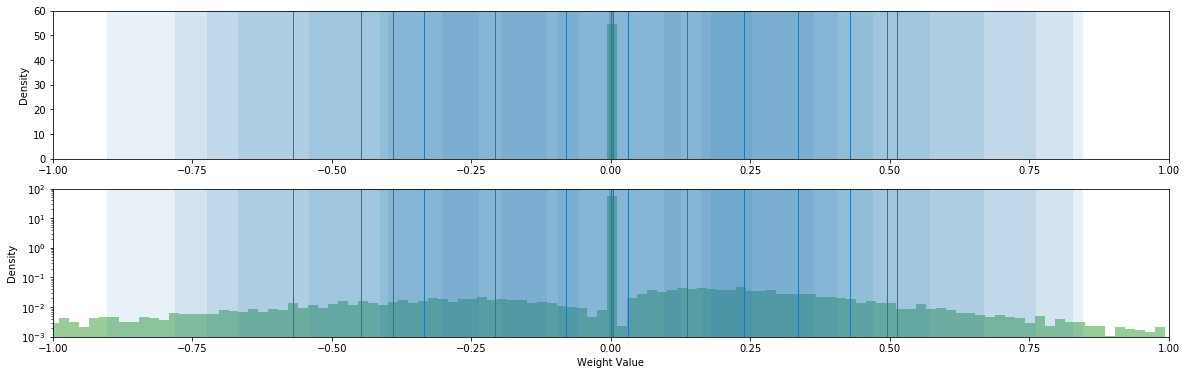

Mean: 10.0 Var: 10.0
Retrain Test: 97.59, Retrain Validation: 0.00, Prune Test: 96.66, Prune Validation: 0.00, Prune Sparsity: 98.25
Retrain Test: 97.97, Retrain Validation: 0.00, Prune Test: 97.16, Prune Validation: 0.00, Prune Sparsity: 97.33
Retrain Test: 98.07, Retrain Validation: 0.00, Prune Test: 97.49, Prune Validation: 0.00, Prune Sparsity: 97.20




<IPython.core.display.Javascript object>

In [11]:
%%notify
_, _, _, _, _, _, res = all_exp(alpha, beta, tau, temp, mixtures, model_name, data_size = 'full')

**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 91.93
Terminating Search - Epoch: 17 - Val Acc: 29.74
Retrain Test: 30.47, Retrain Validation: 29.74, Prune Test: 20.03, Prune Validation: 19.44, Prune Sparsity: 99.93


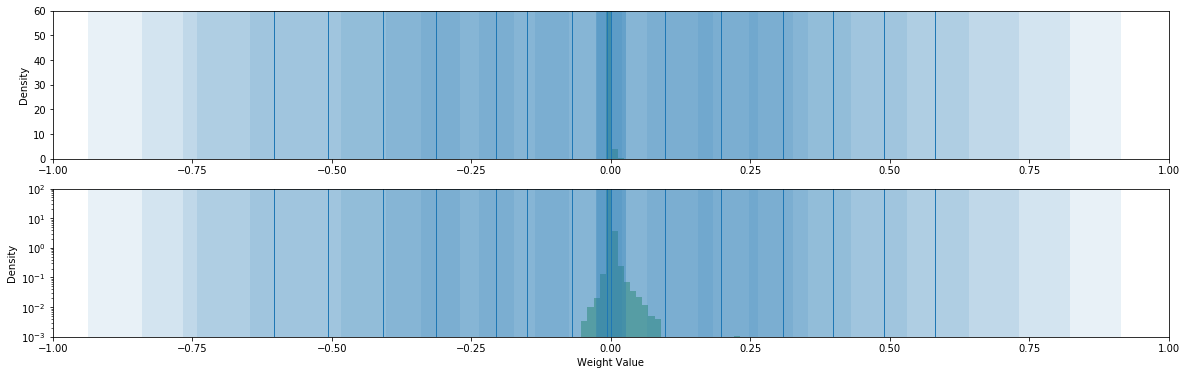

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 95.16
Epoch: 20. Test Accuracy: 86.39
Epoch: 30. Test Accuracy: 78.94
Epoch: 40. Test Accuracy: 77.89
Epoch: 50. Test Accuracy: 80.30
Retrain Test: 80.30, Retrain Validation: 81.19, Prune Test: 18.46, Prune Validation: 18.89, Prune Sparsity: 99.94


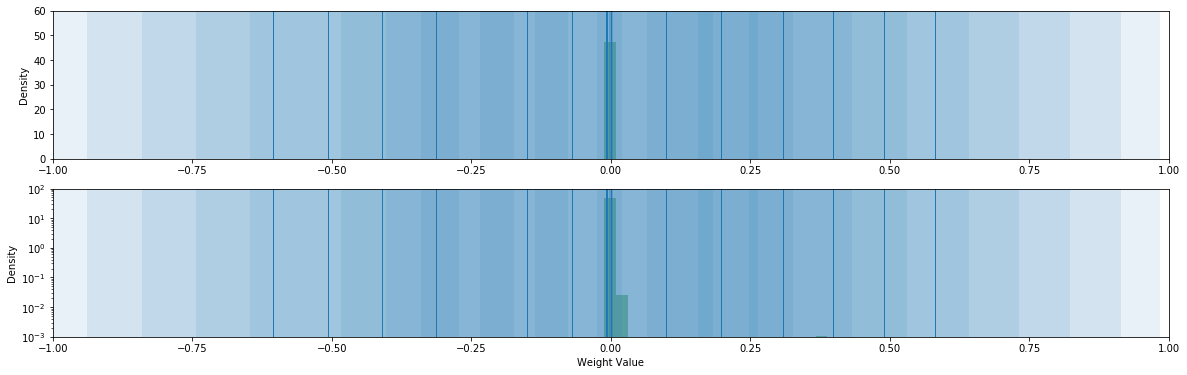

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 96.03
Epoch: 20. Test Accuracy: 87.27
Epoch: 30. Test Accuracy: 78.58
Epoch: 40. Test Accuracy: 76.17
Epoch: 50. Test Accuracy: 78.58
Retrain Test: 78.58, Retrain Validation: 78.64, Prune Test: 30.62, Prune Validation: 30.41, Prune Sparsity: 99.92


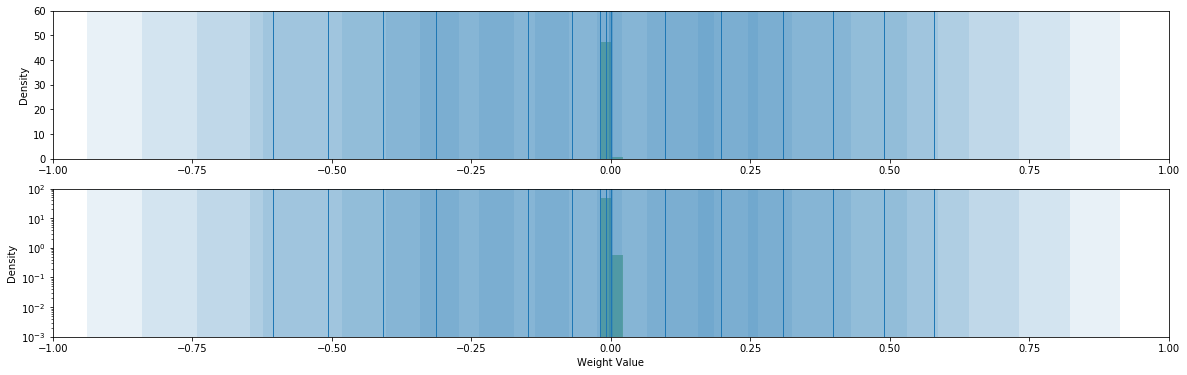

Temp: 1 Tau: 0.0001
Retrain Test: 30.47, Retrain Validation: 29.74, Prune Test: 20.03, Prune Validation: 19.44, Prune Sparsity: 99.93
Retrain Test: 80.30, Retrain Validation: 81.19, Prune Test: 18.46, Prune Validation: 18.89, Prune Sparsity: 99.94
Retrain Test: 78.58, Retrain Validation: 78.64, Prune Test: 30.62, Prune Validation: 30.41, Prune Sparsity: 99.92




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.31
Epoch: 20. Test Accuracy: 93.82
Epoch: 30. Test Accuracy: 89.14
Epoch: 40. Test Accuracy: 87.29
Epoch: 50. Test Accuracy: 86.79
Retrain Test: 86.79, Retrain Validation: 87.05, Prune Test: 42.84, Prune Validation: 44.14, Prune Sparsity: 99.78


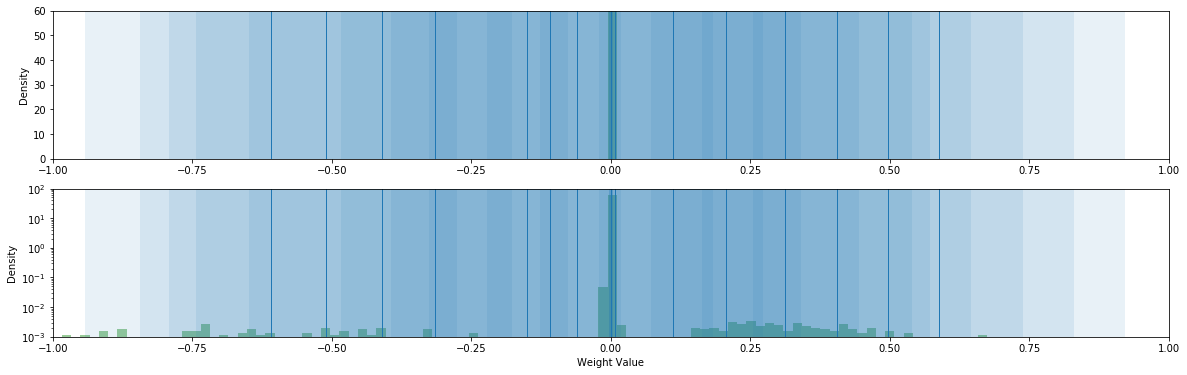

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.69
Epoch: 20. Test Accuracy: 96.27
Epoch: 30. Test Accuracy: 93.81
Epoch: 40. Test Accuracy: 92.37
Epoch: 50. Test Accuracy: 92.38
Retrain Test: 92.38, Retrain Validation: 92.79, Prune Test: 58.01, Prune Validation: 59.69, Prune Sparsity: 99.65


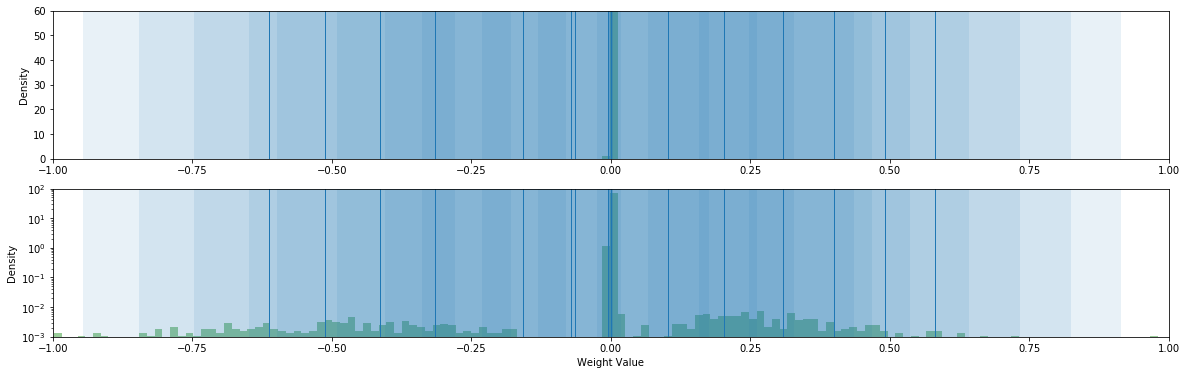

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.84
Epoch: 20. Test Accuracy: 96.50
Epoch: 30. Test Accuracy: 93.72
Epoch: 40. Test Accuracy: 92.11
Epoch: 50. Test Accuracy: 92.37
Retrain Test: 92.37, Retrain Validation: 92.57, Prune Test: 76.47, Prune Validation: 76.73, Prune Sparsity: 99.61


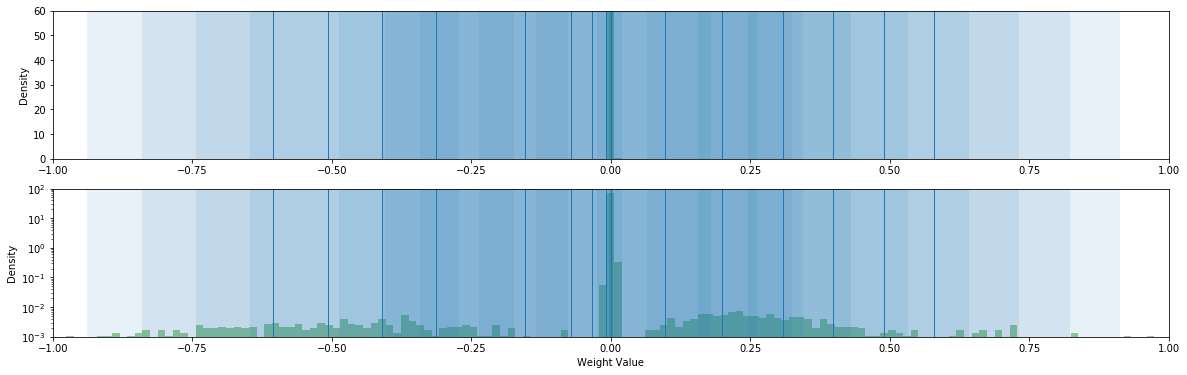

Temp: 1 Tau: 1e-05
Retrain Test: 86.79, Retrain Validation: 87.05, Prune Test: 42.84, Prune Validation: 44.14, Prune Sparsity: 99.78
Retrain Test: 92.38, Retrain Validation: 92.79, Prune Test: 58.01, Prune Validation: 59.69, Prune Sparsity: 99.65
Retrain Test: 92.37, Retrain Validation: 92.57, Prune Test: 76.47, Prune Validation: 76.73, Prune Sparsity: 99.61




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.01
Epoch: 20. Test Accuracy: 97.57
Epoch: 30. Test Accuracy: 96.62
Epoch: 40. Test Accuracy: 95.76
Epoch: 50. Test Accuracy: 95.83
Retrain Test: 95.83, Retrain Validation: 95.85, Prune Test: 91.38, Prune Validation: 91.48, Prune Sparsity: 98.93


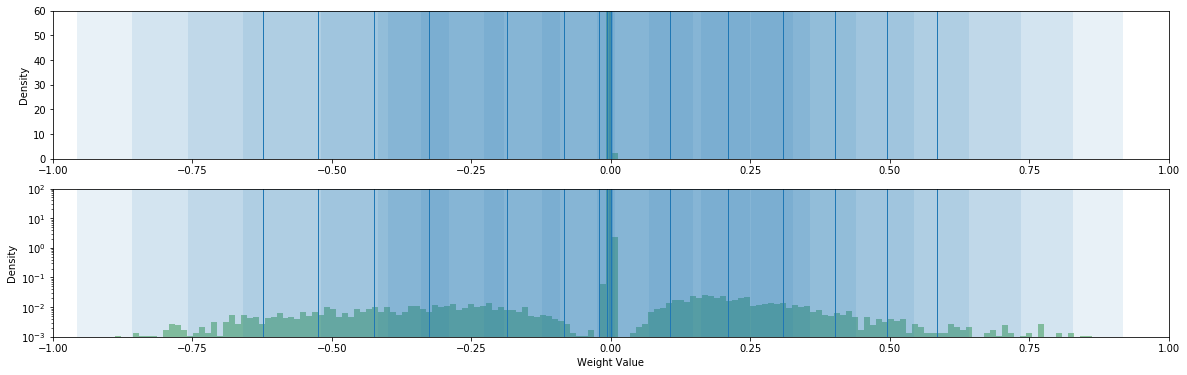

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.92
Epoch: 20. Test Accuracy: 97.72
Epoch: 30. Test Accuracy: 97.12
Epoch: 40. Test Accuracy: 96.58
Epoch: 50. Test Accuracy: 96.58
Retrain Test: 96.58, Retrain Validation: 96.39, Prune Test: 95.35, Prune Validation: 95.22, Prune Sparsity: 98.22


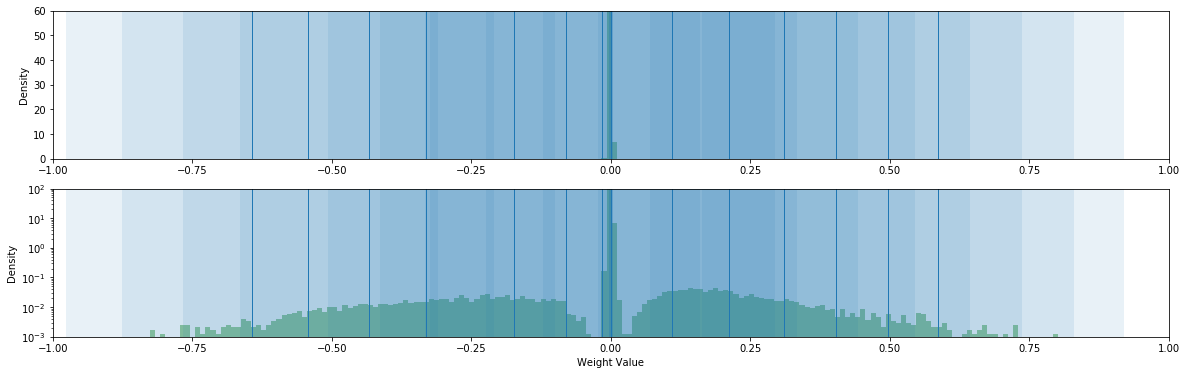

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.72
Epoch: 20. Test Accuracy: 97.72
Epoch: 30. Test Accuracy: 97.27
Epoch: 40. Test Accuracy: 96.85
Epoch: 50. Test Accuracy: 96.67
Retrain Test: 96.67, Retrain Validation: 96.79, Prune Test: 95.25, Prune Validation: 95.09, Prune Sparsity: 98.15


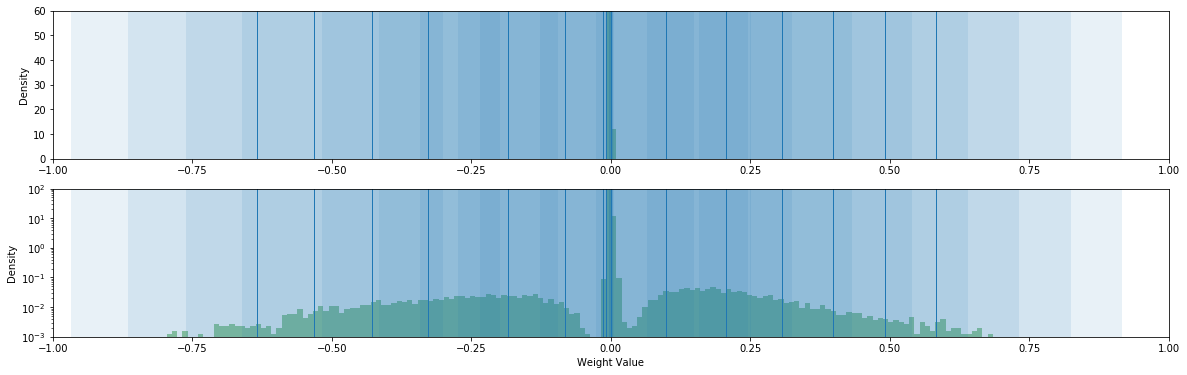

Temp: 1 Tau: 1e-06
Retrain Test: 95.83, Retrain Validation: 95.85, Prune Test: 91.38, Prune Validation: 91.48, Prune Sparsity: 98.93
Retrain Test: 96.58, Retrain Validation: 96.39, Prune Test: 95.35, Prune Validation: 95.22, Prune Sparsity: 98.22
Retrain Test: 96.67, Retrain Validation: 96.79, Prune Test: 95.25, Prune Validation: 95.09, Prune Sparsity: 98.15




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 91.31
Terminating Search - Epoch: 17 - Val Acc: 29.62
Retrain Test: 30.43, Retrain Validation: 29.62, Prune Test: 20.58, Prune Validation: 19.94, Prune Sparsity: 99.94


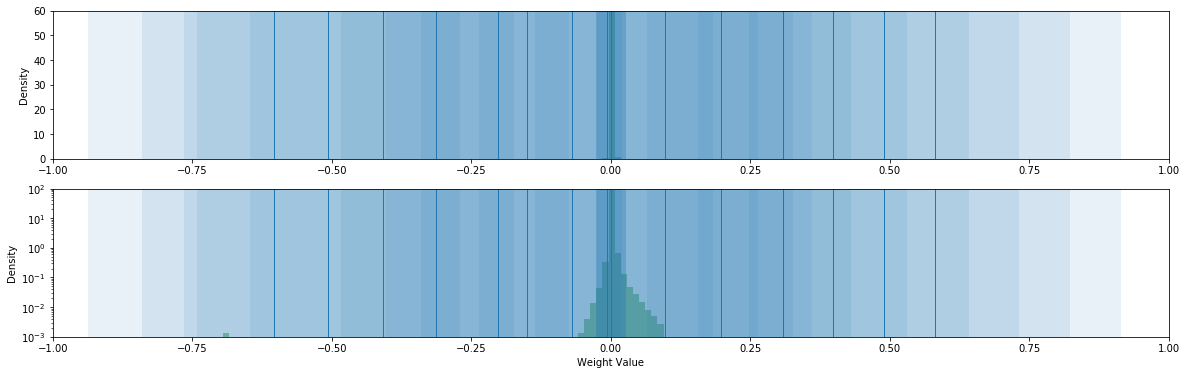

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 93.78
Epoch: 20. Test Accuracy: 84.23
Epoch: 30. Test Accuracy: 73.63
Epoch: 40. Test Accuracy: 67.53
Epoch: 50. Test Accuracy: 68.30
Retrain Test: 68.30, Retrain Validation: 67.98, Prune Test: 26.92, Prune Validation: 27.89, Prune Sparsity: 99.93


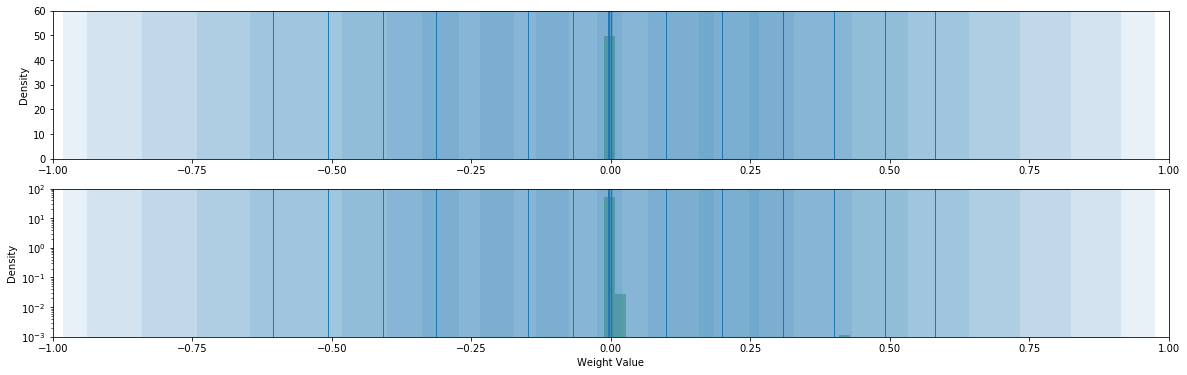

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 94.93
Epoch: 20. Test Accuracy: 85.25
Epoch: 30. Test Accuracy: 70.33
Epoch: 40. Test Accuracy: 64.83
Epoch: 50. Test Accuracy: 65.71
Retrain Test: 65.71, Retrain Validation: 66.30, Prune Test: 34.30, Prune Validation: 36.54, Prune Sparsity: 99.91


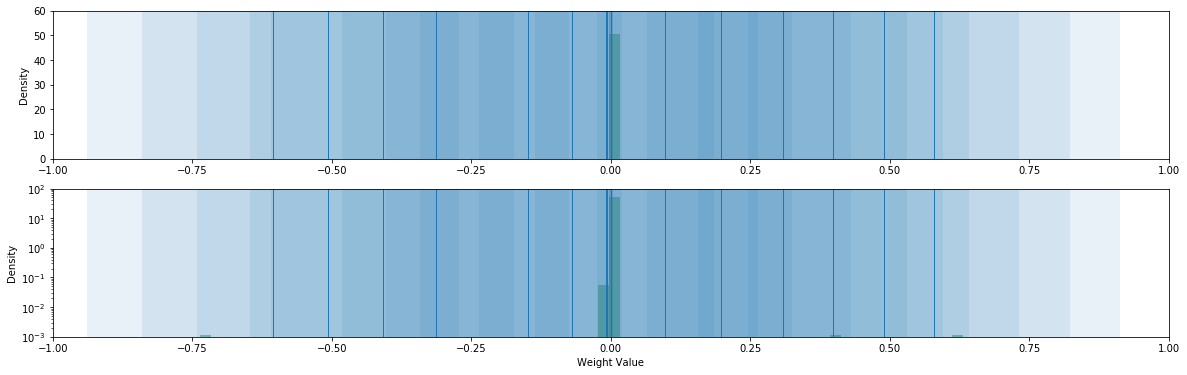

Temp: 2 Tau: 0.0001
Retrain Test: 30.43, Retrain Validation: 29.62, Prune Test: 20.58, Prune Validation: 19.94, Prune Sparsity: 99.94
Retrain Test: 68.30, Retrain Validation: 67.98, Prune Test: 26.92, Prune Validation: 27.89, Prune Sparsity: 99.93
Retrain Test: 65.71, Retrain Validation: 66.30, Prune Test: 34.30, Prune Validation: 36.54, Prune Sparsity: 99.91




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.37
Epoch: 20. Test Accuracy: 93.59
Epoch: 30. Test Accuracy: 89.88
Epoch: 40. Test Accuracy: 86.74
Epoch: 50. Test Accuracy: 87.09
Retrain Test: 87.09, Retrain Validation: 87.41, Prune Test: 30.28, Prune Validation: 31.89, Prune Sparsity: 99.78


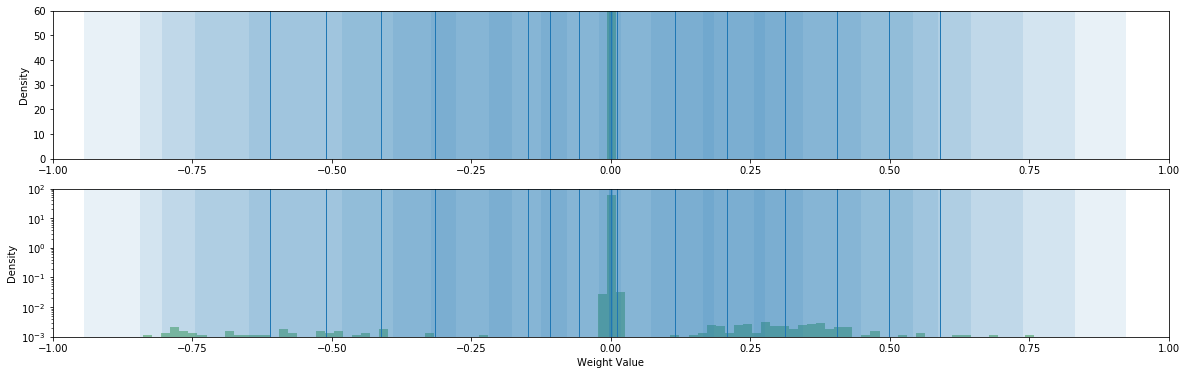

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.15
Epoch: 20. Test Accuracy: 95.41
Epoch: 30. Test Accuracy: 92.59
Epoch: 40. Test Accuracy: 90.77
Epoch: 50. Test Accuracy: 91.25
Retrain Test: 91.25, Retrain Validation: 91.38, Prune Test: 72.25, Prune Validation: 73.19, Prune Sparsity: 99.59


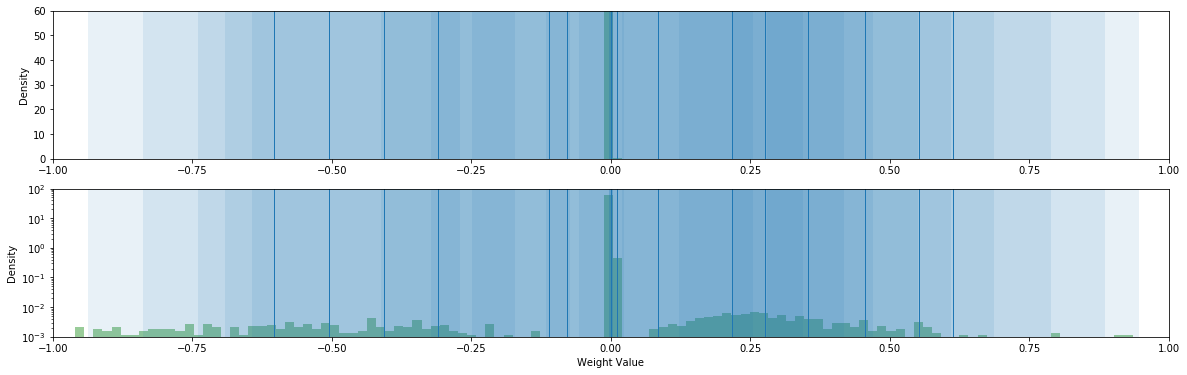

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.26
Epoch: 20. Test Accuracy: 95.62
Epoch: 30. Test Accuracy: 92.45
Epoch: 40. Test Accuracy: 91.23
Epoch: 50. Test Accuracy: 91.34
Retrain Test: 91.34, Retrain Validation: 91.37, Prune Test: 73.53, Prune Validation: 74.20, Prune Sparsity: 99.57


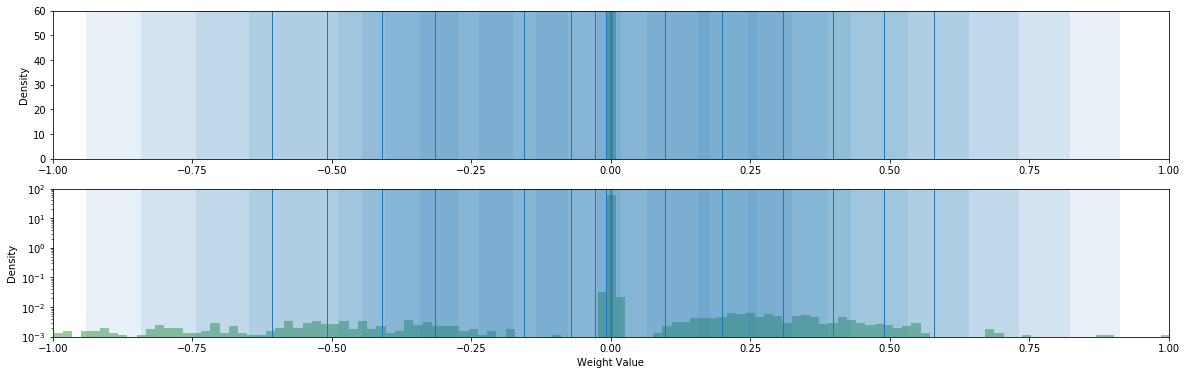

Temp: 2 Tau: 1e-05
Retrain Test: 87.09, Retrain Validation: 87.41, Prune Test: 30.28, Prune Validation: 31.89, Prune Sparsity: 99.78
Retrain Test: 91.25, Retrain Validation: 91.38, Prune Test: 72.25, Prune Validation: 73.19, Prune Sparsity: 99.59
Retrain Test: 91.34, Retrain Validation: 91.37, Prune Test: 73.53, Prune Validation: 74.20, Prune Sparsity: 99.57




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.05
Epoch: 20. Test Accuracy: 97.52
Epoch: 30. Test Accuracy: 96.93
Epoch: 40. Test Accuracy: 96.19
Epoch: 50. Test Accuracy: 95.88
Retrain Test: 95.88, Retrain Validation: 96.03, Prune Test: 93.29, Prune Validation: 93.31, Prune Sparsity: 98.93


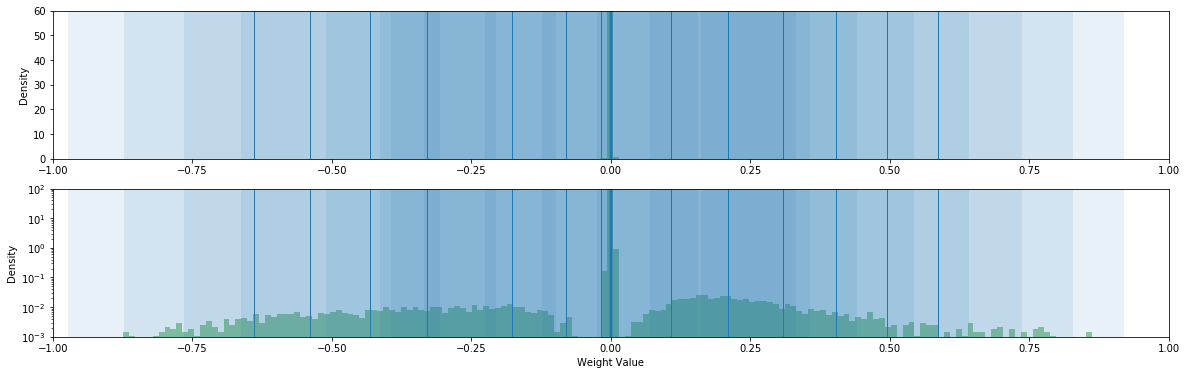

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.90
Epoch: 20. Test Accuracy: 97.40
Epoch: 30. Test Accuracy: 96.84
Epoch: 40. Test Accuracy: 96.65
Epoch: 50. Test Accuracy: 96.56
Retrain Test: 96.56, Retrain Validation: 96.21, Prune Test: 95.16, Prune Validation: 95.01, Prune Sparsity: 98.42


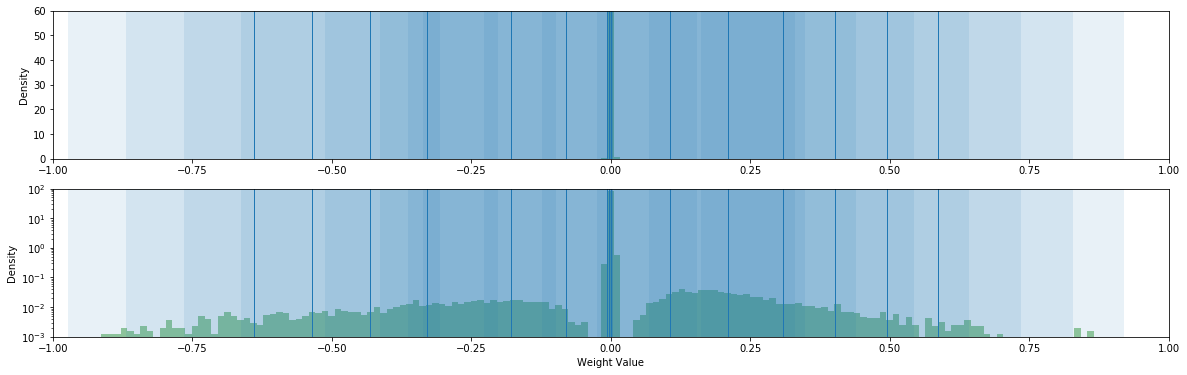

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.93
Epoch: 20. Test Accuracy: 97.53
Epoch: 30. Test Accuracy: 97.23
Epoch: 40. Test Accuracy: 96.38
Epoch: 50. Test Accuracy: 96.56
Retrain Test: 96.56, Retrain Validation: 96.39, Prune Test: 94.51, Prune Validation: 94.26, Prune Sparsity: 98.45


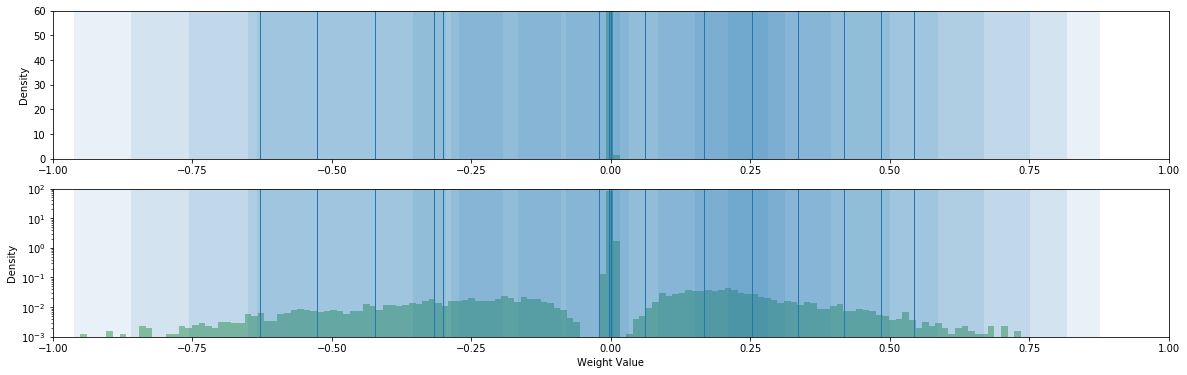

Temp: 2 Tau: 1e-06
Retrain Test: 95.88, Retrain Validation: 96.03, Prune Test: 93.29, Prune Validation: 93.31, Prune Sparsity: 98.93
Retrain Test: 96.56, Retrain Validation: 96.21, Prune Test: 95.16, Prune Validation: 95.01, Prune Sparsity: 98.42
Retrain Test: 96.56, Retrain Validation: 96.39, Prune Test: 94.51, Prune Validation: 94.26, Prune Sparsity: 98.45




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 91.74
Terminating Search - Epoch: 17 - Val Acc: 29.75
Retrain Test: 30.53, Retrain Validation: 29.75, Prune Test: 20.48, Prune Validation: 19.77, Prune Sparsity: 99.94


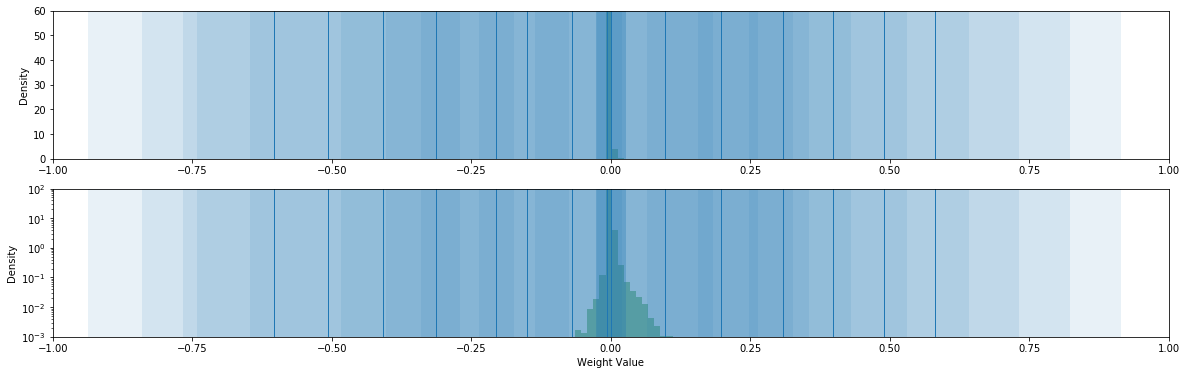

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 91.84
Epoch: 20. Test Accuracy: 75.74
Epoch: 30. Test Accuracy: 65.06
Epoch: 40. Test Accuracy: 59.84
Epoch: 50. Test Accuracy: 61.04
Retrain Test: 61.04, Retrain Validation: 63.23, Prune Test: 24.72, Prune Validation: 25.22, Prune Sparsity: 99.92


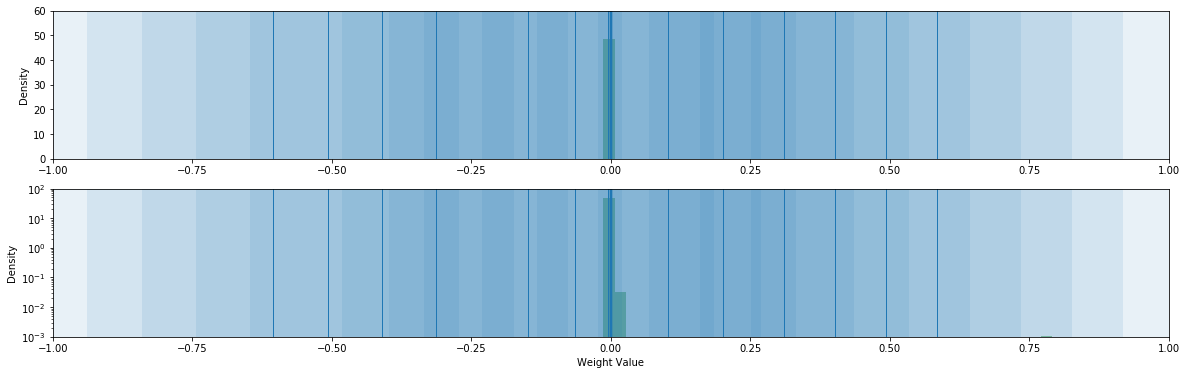

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 93.43
Epoch: 20. Test Accuracy: 80.25
Epoch: 30. Test Accuracy: 63.55
Epoch: 40. Test Accuracy: 59.73
Epoch: 50. Test Accuracy: 60.19
Retrain Test: 60.19, Retrain Validation: 61.75, Prune Test: 28.46, Prune Validation: 28.49, Prune Sparsity: 99.91


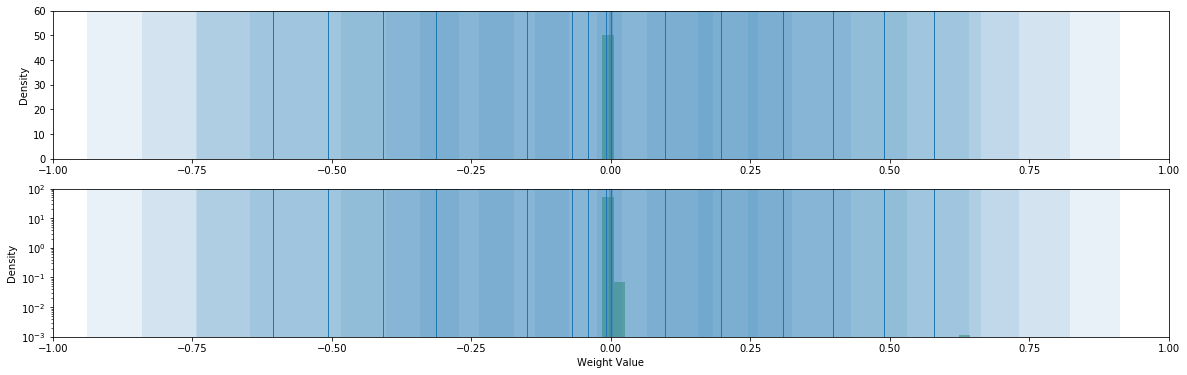

Temp: 4 Tau: 0.0001
Retrain Test: 30.53, Retrain Validation: 29.75, Prune Test: 20.48, Prune Validation: 19.77, Prune Sparsity: 99.94
Retrain Test: 61.04, Retrain Validation: 63.23, Prune Test: 24.72, Prune Validation: 25.22, Prune Sparsity: 99.92
Retrain Test: 60.19, Retrain Validation: 61.75, Prune Test: 28.46, Prune Validation: 28.49, Prune Sparsity: 99.91




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.54
Epoch: 20. Test Accuracy: 93.26
Epoch: 30. Test Accuracy: 88.97
Epoch: 40. Test Accuracy: 87.01
Epoch: 50. Test Accuracy: 87.30
Retrain Test: 87.30, Retrain Validation: 87.69, Prune Test: 40.50, Prune Validation: 42.55, Prune Sparsity: 99.78


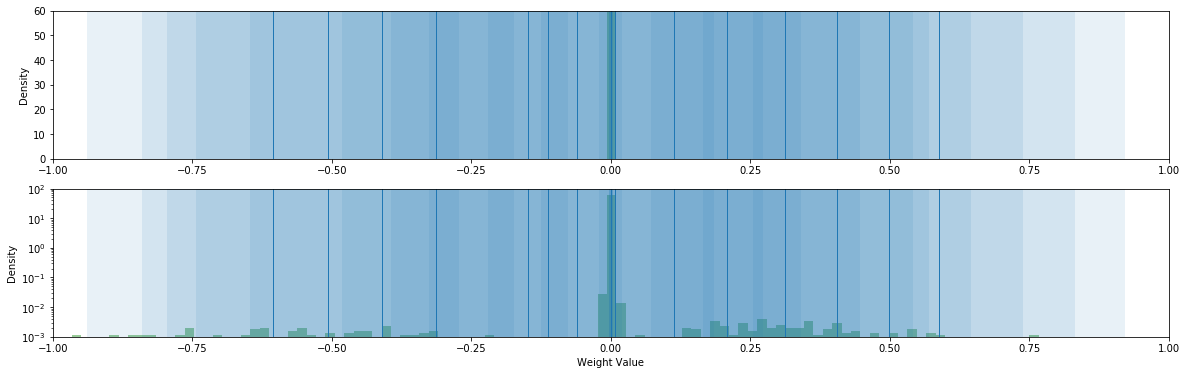

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.31
Epoch: 20. Test Accuracy: 94.95
Epoch: 30. Test Accuracy: 91.63
Epoch: 40. Test Accuracy: 90.24
Epoch: 50. Test Accuracy: 90.53
Retrain Test: 90.53, Retrain Validation: 90.64, Prune Test: 75.98, Prune Validation: 78.12, Prune Sparsity: 99.54


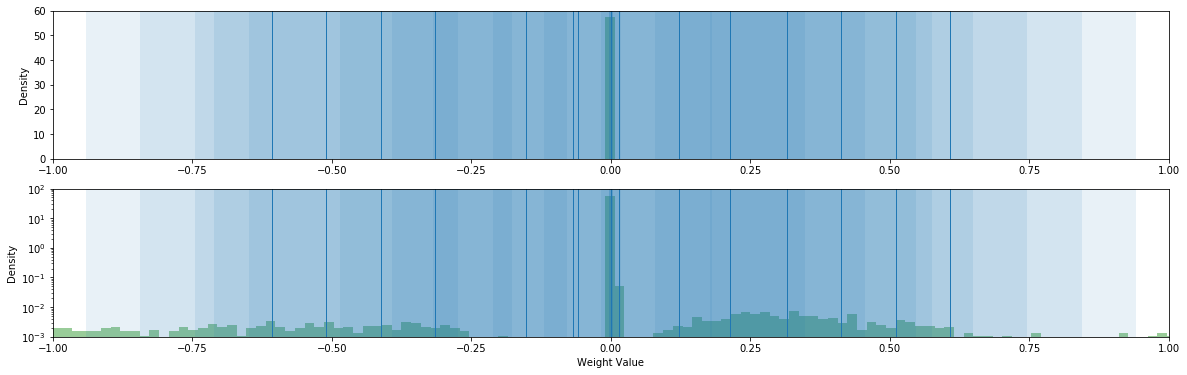

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.26
Epoch: 20. Test Accuracy: 95.21
Epoch: 30. Test Accuracy: 92.04
Epoch: 40. Test Accuracy: 90.69
Epoch: 50. Test Accuracy: 91.03
Retrain Test: 91.03, Retrain Validation: 91.02, Prune Test: 77.24, Prune Validation: 79.03, Prune Sparsity: 99.53


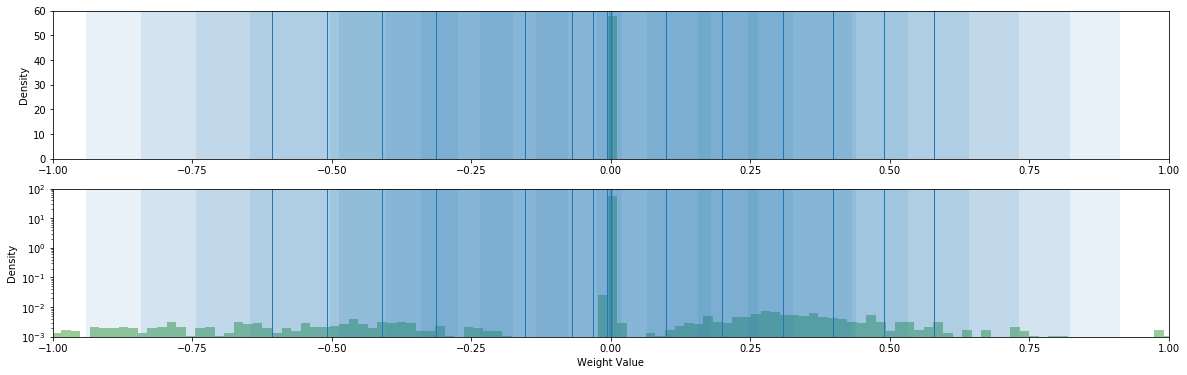

Temp: 4 Tau: 1e-05
Retrain Test: 87.30, Retrain Validation: 87.69, Prune Test: 40.50, Prune Validation: 42.55, Prune Sparsity: 99.78
Retrain Test: 90.53, Retrain Validation: 90.64, Prune Test: 75.98, Prune Validation: 78.12, Prune Sparsity: 99.54
Retrain Test: 91.03, Retrain Validation: 91.02, Prune Test: 77.24, Prune Validation: 79.03, Prune Sparsity: 99.53




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.48
Epoch: 20. Test Accuracy: 97.54
Epoch: 30. Test Accuracy: 96.79
Epoch: 40. Test Accuracy: 95.83
Epoch: 50. Test Accuracy: 95.46
Retrain Test: 95.46, Retrain Validation: 95.69, Prune Test: 93.32, Prune Validation: 93.03, Prune Sparsity: 98.93


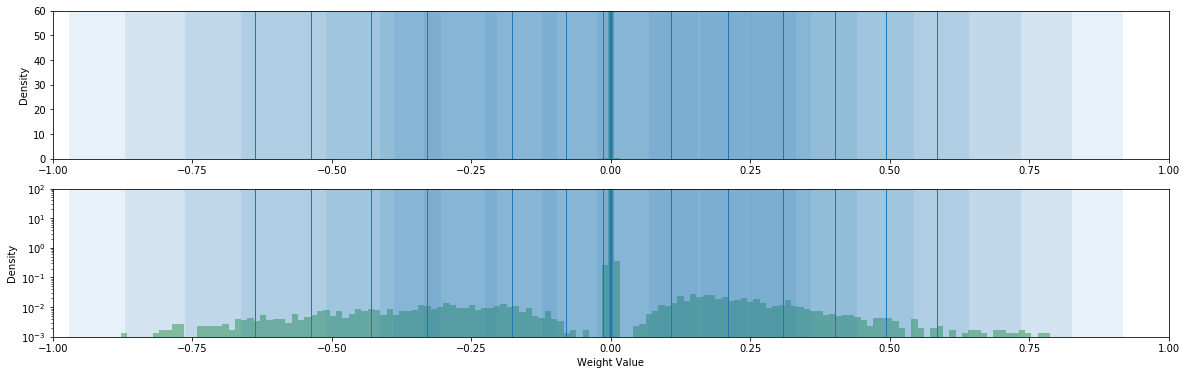

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.04
Epoch: 20. Test Accuracy: 97.67
Epoch: 30. Test Accuracy: 97.22
Epoch: 40. Test Accuracy: 96.66
Epoch: 50. Test Accuracy: 96.50
Retrain Test: 96.50, Retrain Validation: 96.19, Prune Test: 95.24, Prune Validation: 95.00, Prune Sparsity: 98.37


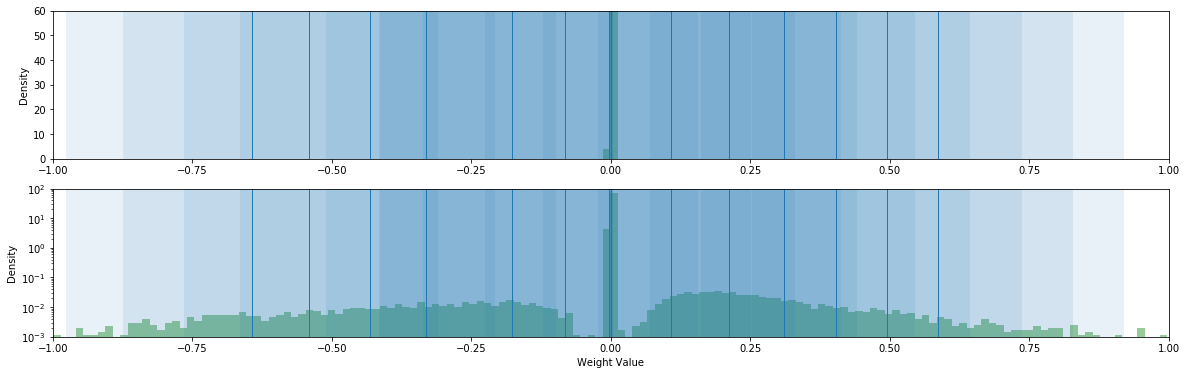

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.98
Epoch: 20. Test Accuracy: 97.60
Epoch: 30. Test Accuracy: 96.77
Epoch: 40. Test Accuracy: 96.53
Epoch: 50. Test Accuracy: 96.67
Retrain Test: 96.67, Retrain Validation: 96.43, Prune Test: 95.82, Prune Validation: 95.44, Prune Sparsity: 98.34


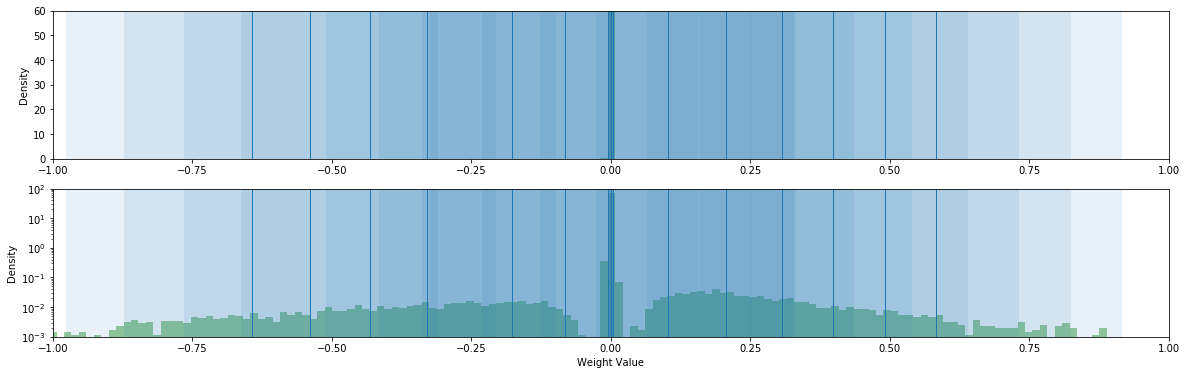

Temp: 4 Tau: 1e-06
Retrain Test: 95.46, Retrain Validation: 95.69, Prune Test: 93.32, Prune Validation: 93.03, Prune Sparsity: 98.93
Retrain Test: 96.50, Retrain Validation: 96.19, Prune Test: 95.24, Prune Validation: 95.00, Prune Sparsity: 98.37
Retrain Test: 96.67, Retrain Validation: 96.43, Prune Test: 95.82, Prune Validation: 95.44, Prune Sparsity: 98.34




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 91.33
Terminating Search - Epoch: 17 - Val Acc: 29.67
Retrain Test: 30.37, Retrain Validation: 29.67, Prune Test: 19.93, Prune Validation: 19.31, Prune Sparsity: 99.93


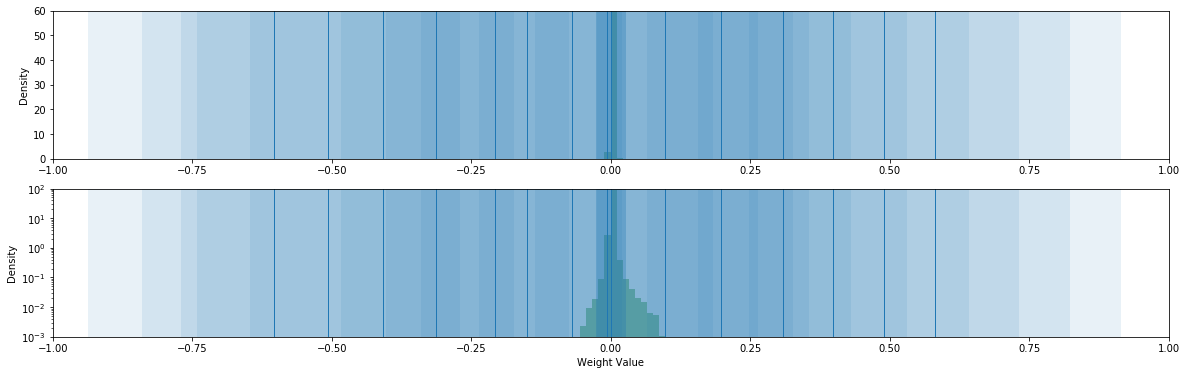

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 88.67
Terminating Search - Epoch: 17 - Val Acc: 49.36
Retrain Test: 48.71, Retrain Validation: 49.36, Prune Test: 34.04, Prune Validation: 35.13, Prune Sparsity: 99.79


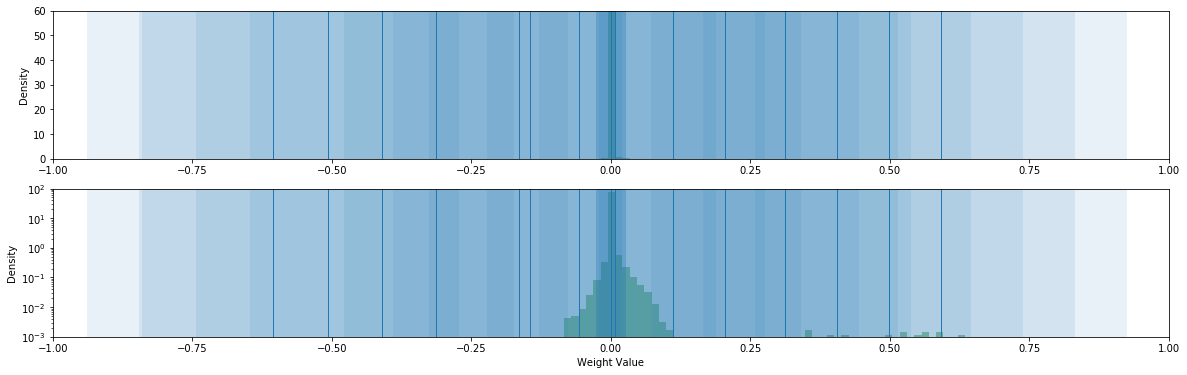

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 90.55
Epoch: 20. Test Accuracy: 53.75
Terminating Search - Epoch: 21 - Val Acc: 48.55
Retrain Test: 47.92, Retrain Validation: 48.55, Prune Test: 30.04, Prune Validation: 28.61, Prune Sparsity: 99.91


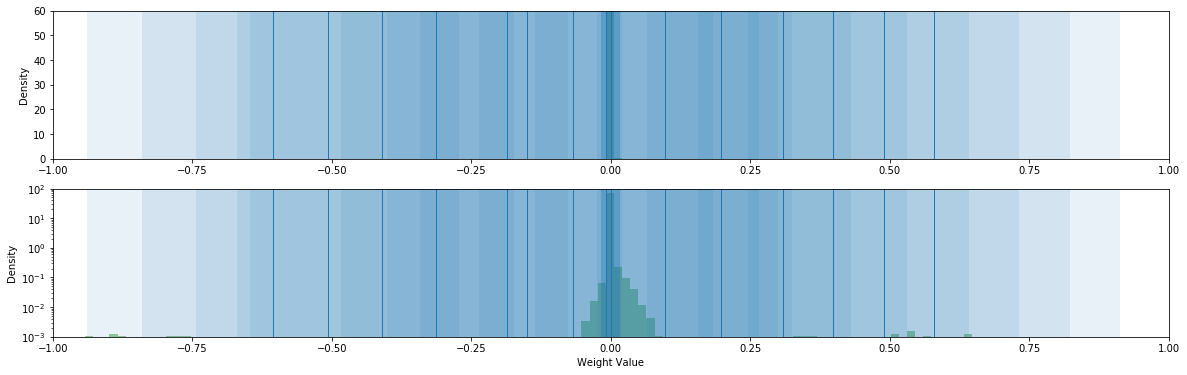

Temp: 10 Tau: 0.0001
Retrain Test: 30.37, Retrain Validation: 29.67, Prune Test: 19.93, Prune Validation: 19.31, Prune Sparsity: 99.93
Retrain Test: 48.71, Retrain Validation: 49.36, Prune Test: 34.04, Prune Validation: 35.13, Prune Sparsity: 99.79
Retrain Test: 47.92, Retrain Validation: 48.55, Prune Test: 30.04, Prune Validation: 28.61, Prune Sparsity: 99.91




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 96.96
Epoch: 20. Test Accuracy: 93.91
Epoch: 30. Test Accuracy: 89.58
Epoch: 40. Test Accuracy: 86.19
Epoch: 50. Test Accuracy: 87.10
Retrain Test: 87.10, Retrain Validation: 87.86, Prune Test: 37.35, Prune Validation: 39.21, Prune Sparsity: 99.77


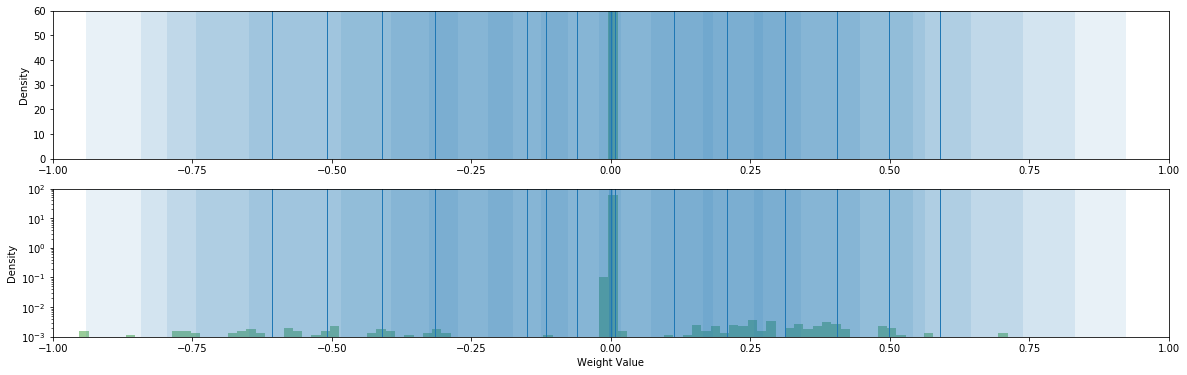

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 96.91
Epoch: 20. Test Accuracy: 93.02
Epoch: 30. Test Accuracy: 90.10
Epoch: 40. Test Accuracy: 89.31
Epoch: 50. Test Accuracy: 89.69
Retrain Test: 89.69, Retrain Validation: 89.92, Prune Test: 74.06, Prune Validation: 74.74, Prune Sparsity: 99.58


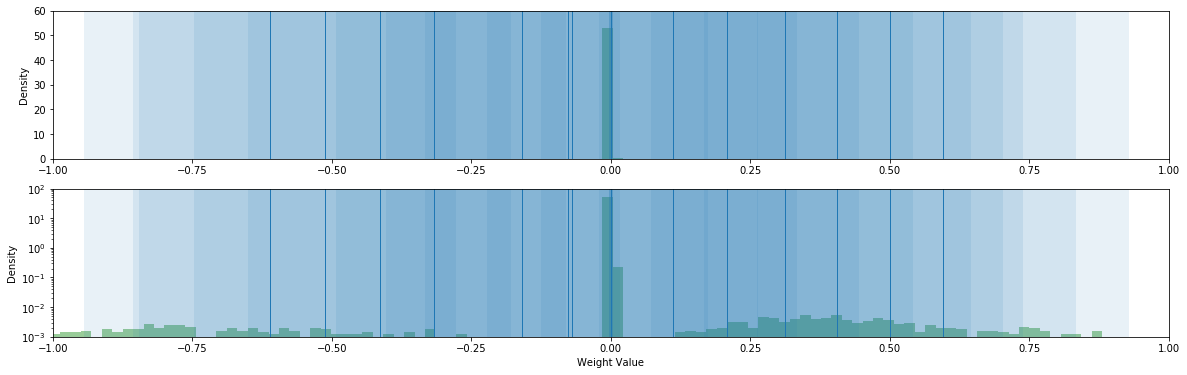

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.15
Epoch: 20. Test Accuracy: 93.41
Epoch: 30. Test Accuracy: 90.65
Epoch: 40. Test Accuracy: 89.62
Epoch: 50. Test Accuracy: 89.87
Retrain Test: 89.87, Retrain Validation: 90.44, Prune Test: 77.28, Prune Validation: 77.89, Prune Sparsity: 99.55


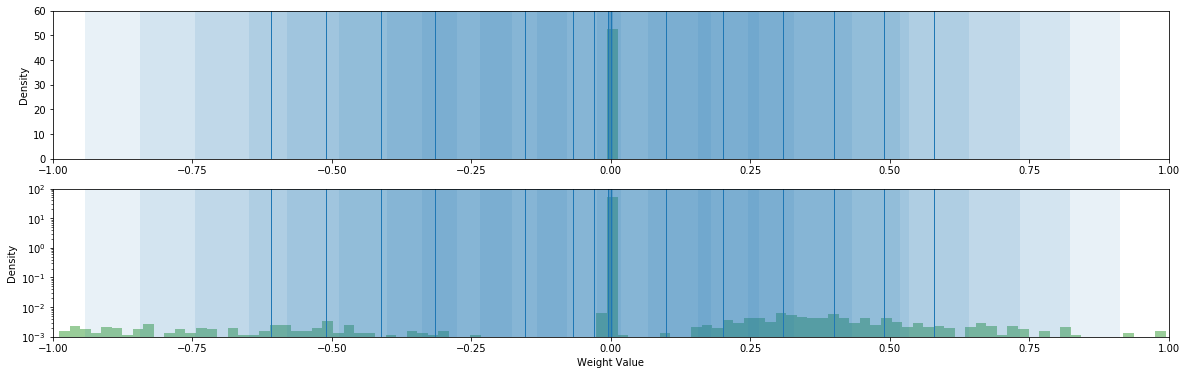

Temp: 10 Tau: 1e-05
Retrain Test: 87.10, Retrain Validation: 87.86, Prune Test: 37.35, Prune Validation: 39.21, Prune Sparsity: 99.77
Retrain Test: 89.69, Retrain Validation: 89.92, Prune Test: 74.06, Prune Validation: 74.74, Prune Sparsity: 99.58
Retrain Test: 89.87, Retrain Validation: 90.44, Prune Test: 77.28, Prune Validation: 77.89, Prune Sparsity: 99.55




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.92
Epoch: 20. Test Accuracy: 97.56
Epoch: 30. Test Accuracy: 96.86
Epoch: 40. Test Accuracy: 96.17
Epoch: 50. Test Accuracy: 95.92
Retrain Test: 95.92, Retrain Validation: 95.95, Prune Test: 92.64, Prune Validation: 92.67, Prune Sparsity: 98.93


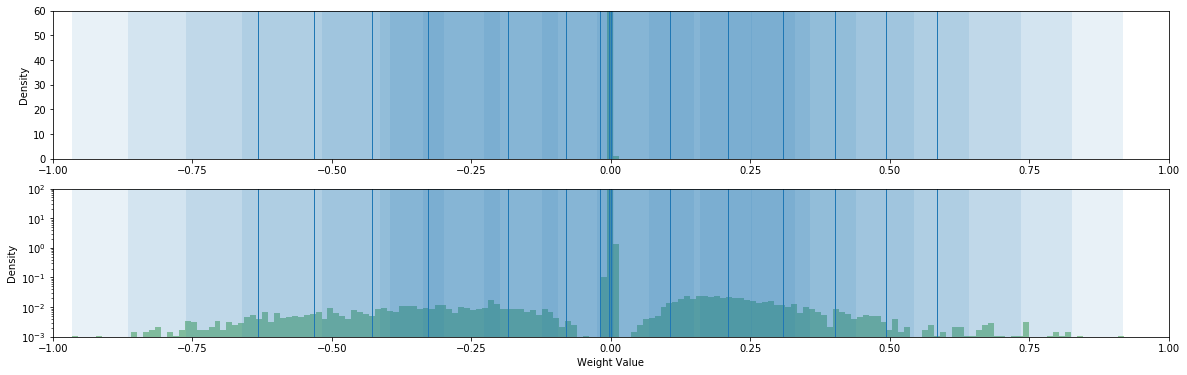

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.14
Epoch: 20. Test Accuracy: 97.73
Epoch: 30. Test Accuracy: 97.05
Epoch: 40. Test Accuracy: 96.44
Epoch: 50. Test Accuracy: 96.54
Retrain Test: 96.54, Retrain Validation: 96.52, Prune Test: 93.44, Prune Validation: 93.41, Prune Sparsity: 98.72


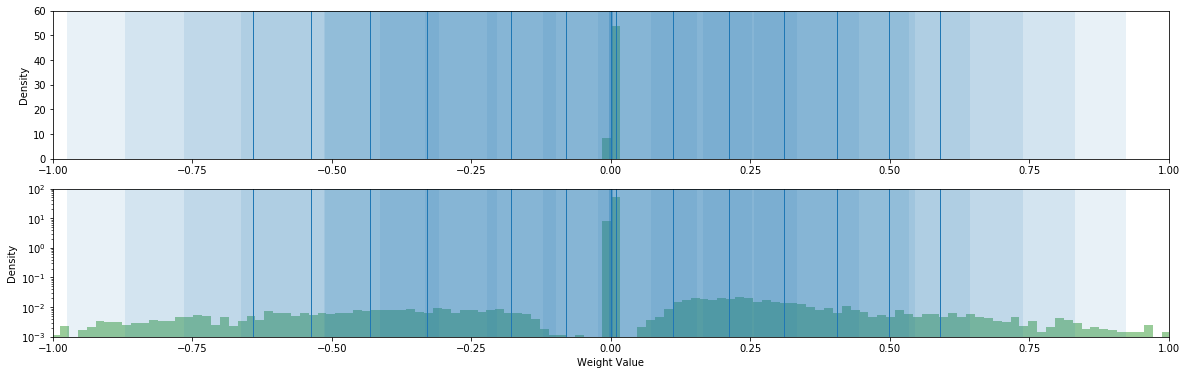

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.14
Epoch: 20. Test Accuracy: 97.69
Epoch: 30. Test Accuracy: 97.13
Epoch: 40. Test Accuracy: 96.38
Epoch: 50. Test Accuracy: 96.62
Retrain Test: 96.62, Retrain Validation: 96.42, Prune Test: 95.25, Prune Validation: 95.14, Prune Sparsity: 98.71


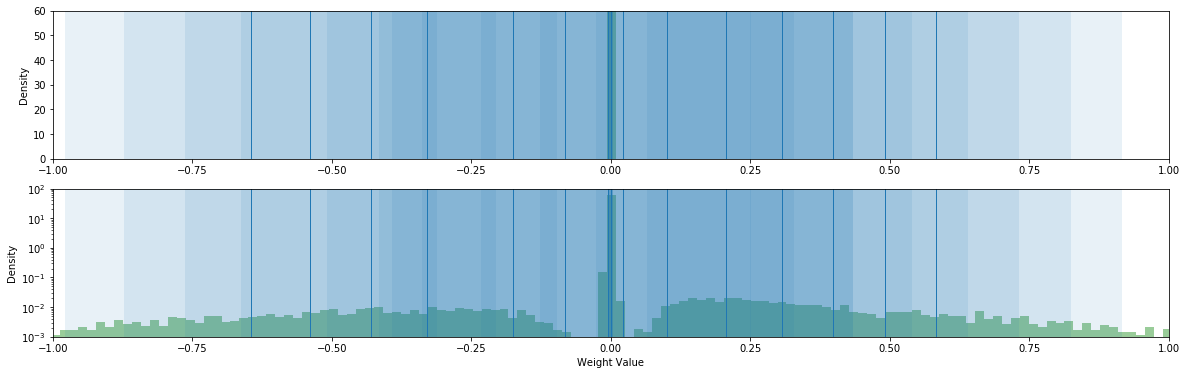

Temp: 10 Tau: 1e-06
Retrain Test: 95.92, Retrain Validation: 95.95, Prune Test: 92.64, Prune Validation: 92.67, Prune Sparsity: 98.93
Retrain Test: 96.54, Retrain Validation: 96.52, Prune Test: 93.44, Prune Validation: 93.41, Prune Sparsity: 98.72
Retrain Test: 96.62, Retrain Validation: 96.42, Prune Test: 95.25, Prune Validation: 95.14, Prune Sparsity: 98.71




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 91.47
Terminating Search - Epoch: 17 - Val Acc: 29.73
Retrain Test: 30.41, Retrain Validation: 29.73, Prune Test: 20.26, Prune Validation: 19.52, Prune Sparsity: 99.93


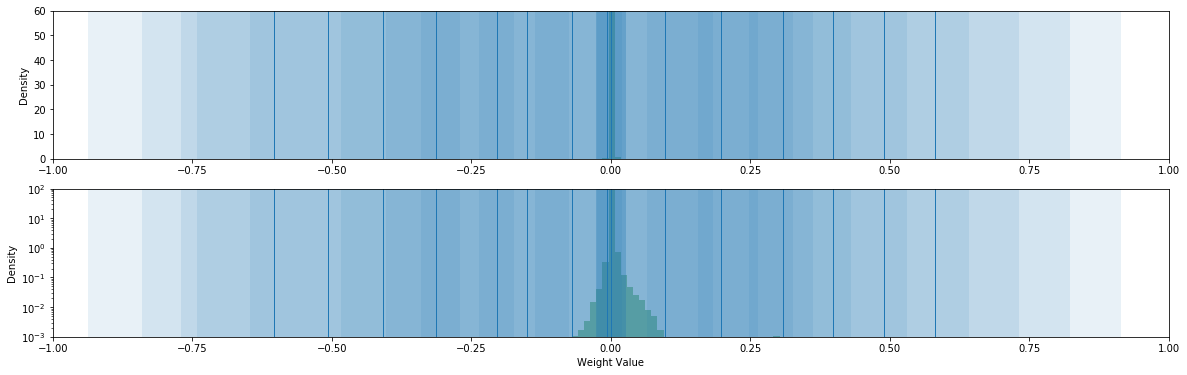

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 62.12
Terminating Search - Epoch: 13 - Val Acc: 18.76
Retrain Test: 19.55, Retrain Validation: 18.76, Prune Test: 9.80, Prune Validation: 9.91, Prune Sparsity: 99.94


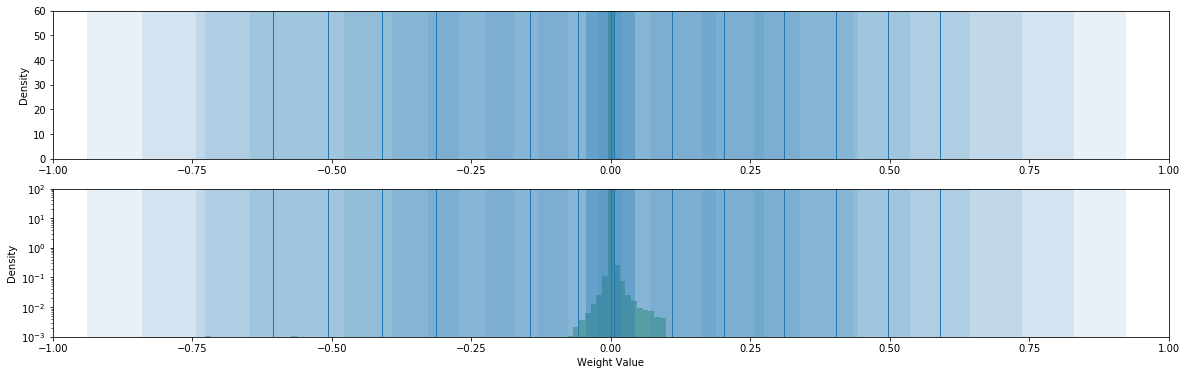

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 81.61
Terminating Search - Epoch: 13 - Val Acc: 46.99
Retrain Test: 46.15, Retrain Validation: 46.99, Prune Test: 20.15, Prune Validation: 19.63, Prune Sparsity: 99.62


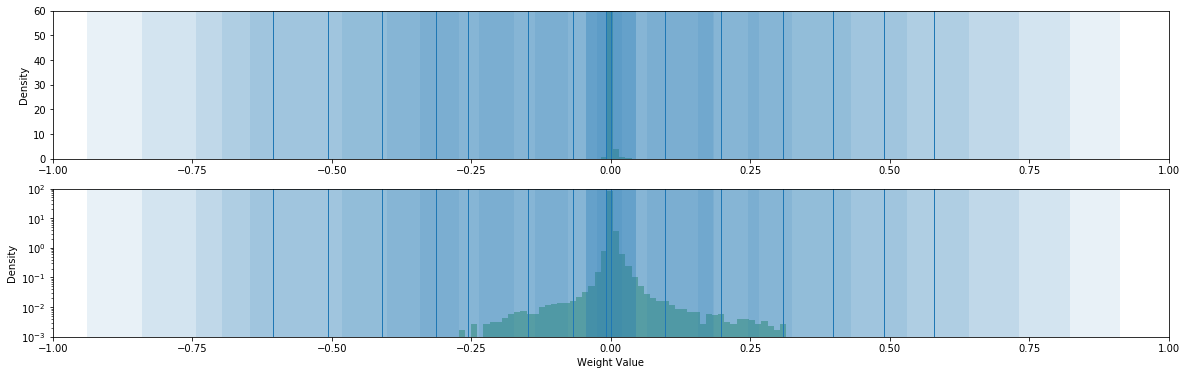

Temp: 20 Tau: 0.0001
Retrain Test: 30.41, Retrain Validation: 29.73, Prune Test: 20.26, Prune Validation: 19.52, Prune Sparsity: 99.93
Retrain Test: 19.55, Retrain Validation: 18.76, Prune Test: 9.80, Prune Validation: 9.91, Prune Sparsity: 99.94
Retrain Test: 46.15, Retrain Validation: 46.99, Prune Test: 20.15, Prune Validation: 19.63, Prune Sparsity: 99.62




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.30
Epoch: 20. Test Accuracy: 93.46
Epoch: 30. Test Accuracy: 89.25
Epoch: 40. Test Accuracy: 87.03
Epoch: 50. Test Accuracy: 87.05
Retrain Test: 87.05, Retrain Validation: 87.53, Prune Test: 42.21, Prune Validation: 43.25, Prune Sparsity: 99.78


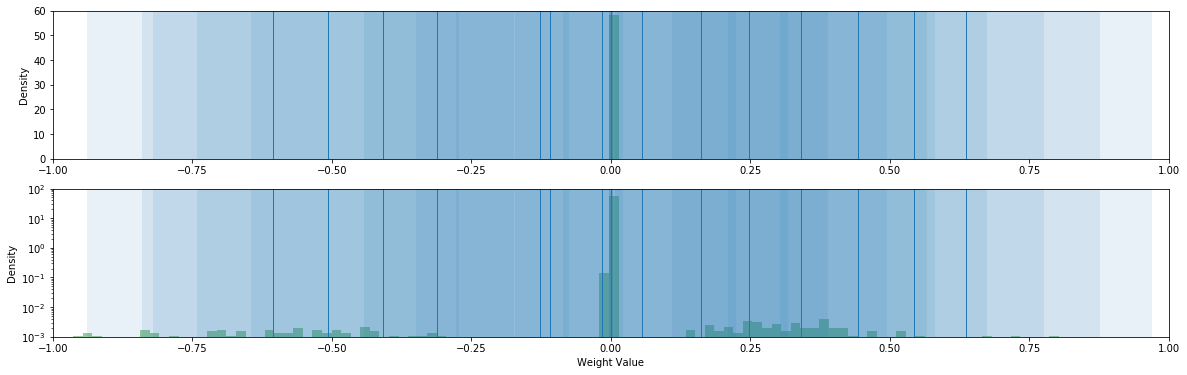

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 95.09
Epoch: 20. Test Accuracy: 88.22
Epoch: 30. Test Accuracy: 83.60
Epoch: 40. Test Accuracy: 83.34
Epoch: 50. Test Accuracy: 84.33
Retrain Test: 84.33, Retrain Validation: 84.60, Prune Test: 58.40, Prune Validation: 60.32, Prune Sparsity: 99.70


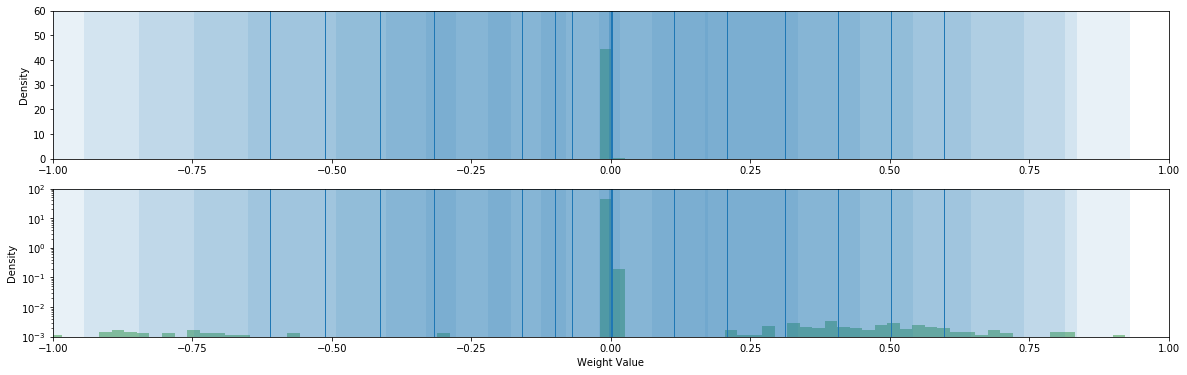

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 95.72
Epoch: 20. Test Accuracy: 89.06
Epoch: 30. Test Accuracy: 84.73
Epoch: 40. Test Accuracy: 83.89
Epoch: 50. Test Accuracy: 84.53
Retrain Test: 84.53, Retrain Validation: 84.93, Prune Test: 68.64, Prune Validation: 70.01, Prune Sparsity: 99.67


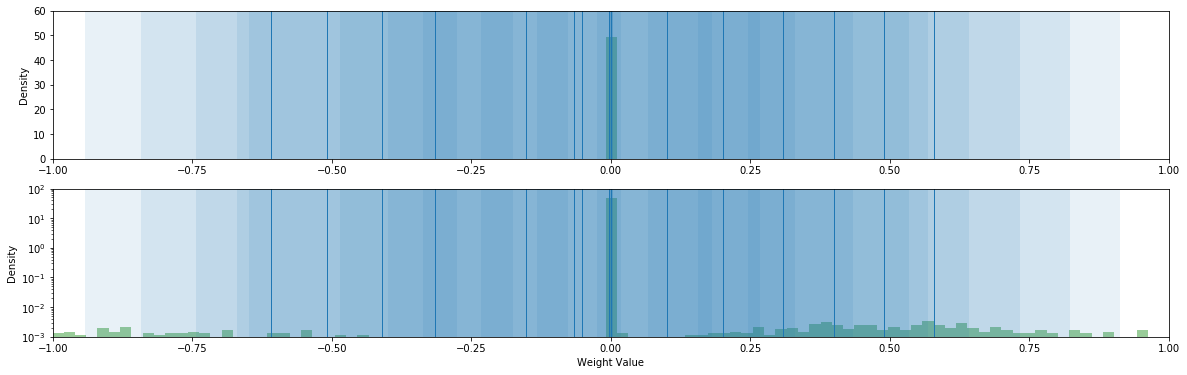

Temp: 20 Tau: 1e-05
Retrain Test: 87.05, Retrain Validation: 87.53, Prune Test: 42.21, Prune Validation: 43.25, Prune Sparsity: 99.78
Retrain Test: 84.33, Retrain Validation: 84.60, Prune Test: 58.40, Prune Validation: 60.32, Prune Sparsity: 99.70
Retrain Test: 84.53, Retrain Validation: 84.93, Prune Test: 68.64, Prune Validation: 70.01, Prune Sparsity: 99.67




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.09
Epoch: 20. Test Accuracy: 97.49
Epoch: 30. Test Accuracy: 96.78
Epoch: 40. Test Accuracy: 96.05
Epoch: 50. Test Accuracy: 95.80
Retrain Test: 95.80, Retrain Validation: 95.93, Prune Test: 93.02, Prune Validation: 93.17, Prune Sparsity: 98.91


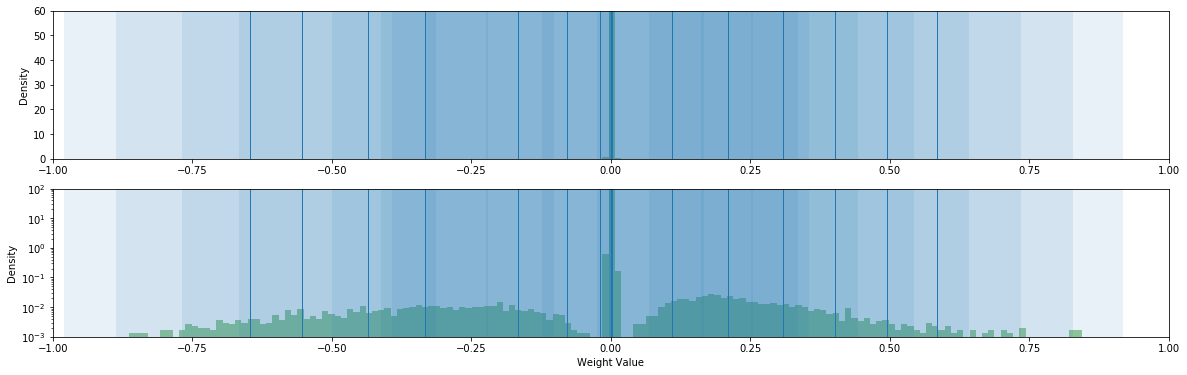

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.96
Epoch: 20. Test Accuracy: 97.15
Epoch: 30. Test Accuracy: 95.52
Epoch: 40. Test Accuracy: 94.82
Epoch: 50. Test Accuracy: 94.98
Retrain Test: 94.98, Retrain Validation: 95.30, Prune Test: 84.11, Prune Validation: 85.23, Prune Sparsity: 99.15


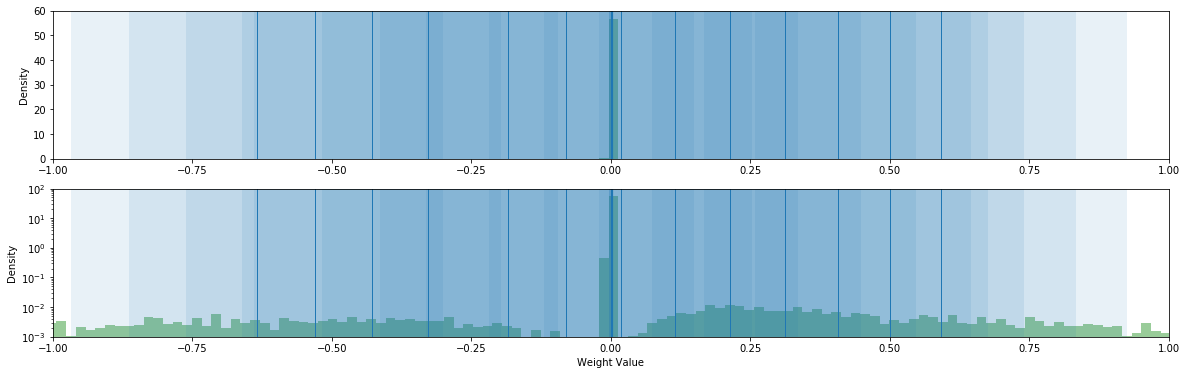

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.91
Epoch: 20. Test Accuracy: 97.23
Epoch: 30. Test Accuracy: 95.72
Epoch: 40. Test Accuracy: 94.90
Epoch: 50. Test Accuracy: 95.15
Retrain Test: 95.15, Retrain Validation: 95.43, Prune Test: 91.20, Prune Validation: 92.06, Prune Sparsity: 99.13


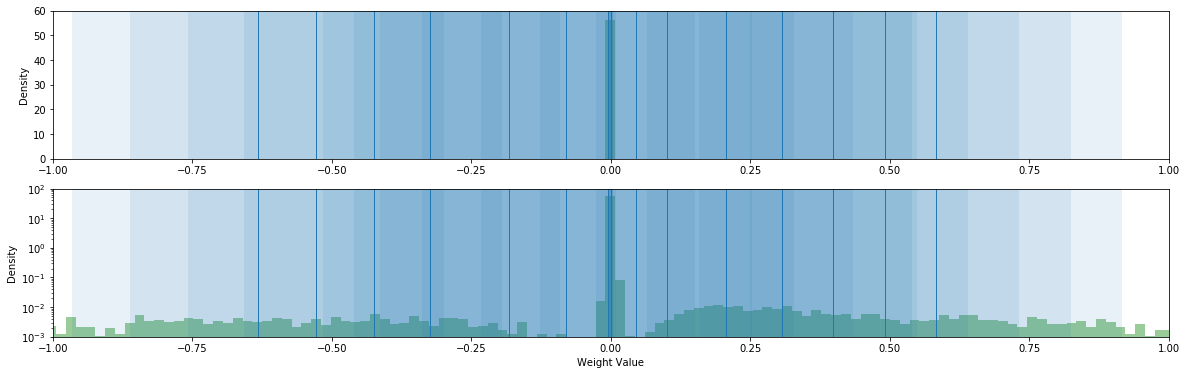

Temp: 20 Tau: 1e-06
Retrain Test: 95.80, Retrain Validation: 95.93, Prune Test: 93.02, Prune Validation: 93.17, Prune Sparsity: 98.91
Retrain Test: 94.98, Retrain Validation: 95.30, Prune Test: 84.11, Prune Validation: 85.23, Prune Sparsity: 99.15
Retrain Test: 95.15, Retrain Validation: 95.43, Prune Test: 91.20, Prune Validation: 92.06, Prune Sparsity: 99.13


Temp: 1 Tau: 0.0001
Retrain Test: 30.47, Retrain Validation: 29.74, Prune Test: 20.03, Prune Validation: 19.44, Prune Sparsity: 99.93
Retrain Test: 80.30, Retrain Validation: 81.19, Prune Test: 18.46, Prune Validation: 18.89, Prune Sparsity: 99.94
Retrain Test: 78.58, Retrain Validation: 78.64, Prune Test: 30.62, Prune Validation: 30.41, Prune Sparsity: 99.92

Temp: 1 Tau: 1e-05
Retrain Test: 86.79, Retrain Validation: 87.05, Prune Test: 42.84, Prune Validation: 44.14, Prune Sparsity: 99.78
Retrain Test: 92.38, Retrain Validation: 92.79, Prune Test: 58.01, Prune Validation: 59.69, Prune Sparsity: 99.65
Retrain Test: 92.37, Retra

<IPython.core.display.Javascript object>

In [14]:
%%notify
res_str = ""
for temp in [1, 2, 4, 10, 20]:
    for tau in [1e-4, 1e-5, 1e-6]:
        _, _, _, _, _, _, res = all_exp(alpha, beta, tau, temp, mixtures, model_name)
        res_str = res_str + res
print (res_str)